In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = '~/datasets'

batch_size = 100

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 400
latent_dim = 40

# Learning rate
lr = 1e-3 # Karpathy constant

# Number of epoch
epochs = 15 

In [3]:

#Input img -> Hidden dim -> mean, std -> Reparameterization trick -> Decoder -> Output img
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.sigma_layer = nn.Linear(hidden_dim, latent_dim)
        
        self.relu = nn.ReLU()


    def forward(self, x):
        hidden = self.relu(self.input_to_hidden(x))
        mu, sigma = self.mu_layer(hidden), self.sigma_layer(hidden)
        return mu, sigma



In [4]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()


    def forward(self, z):
        hidden = self.relu(self.latent_to_hidden(z))
        return torch.sigmoid(self.hidden_to_output(hidden))

In [5]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, sigma):
        # reparameterization trick
        epsilon = torch.randn_like(sigma)
        z = mean + epsilon * sigma
        return z
        
    
    def forward(self, x):
        mean, sigma = self.Encoder(x) #input -> hidden -> mean, std
        z = self.reparameterization(mean, sigma) #repereameterization trick
        theta = self.Decoder(z) #z -> hidden -> output
        return theta, mean, sigma
        
        

In [6]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


In [7]:
x = torch.randn(4, 28*28)
vae = Model(Encoder=encoder, Decoder=decoder)
theta, mean, sigma = vae(x)
print(f"Theta shape: {theta.shape}, mean shape: {mean.shape}, sigma shape: {sigma.shape}")


Theta shape: torch.Size([4, 784]), mean shape: torch.Size([4, 40]), sigma shape: torch.Size([4, 40])


In [8]:
#Training
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image, make_grid


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

#Transform dvidides by 255 
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True,  download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)





In [9]:
def loss_function(x, theta, mean, sigma):
    # reconstruction loss
    loss_function = torch.nn.BCELoss(reduction='sum')
    recon_loss = loss_function(theta, x)
    kl_div = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mean.pow(2) - sigma.pow(2))
    
    return recon_loss + kl_div

Start training...


Epoch [0/15]: : 600it [00:25, 23.31it/s, loss=1.3e+4] 
Epoch [1/15]: : 600it [00:25, 23.76it/s, loss=1.2e+4] 
Epoch [2/15]: : 600it [00:23, 25.98it/s, loss=1.16e+4]
Epoch [3/15]: : 600it [00:24, 24.62it/s, loss=1.1e+4] 
Epoch [4/15]: : 600it [00:26, 22.70it/s, loss=1.06e+4]
Epoch [5/15]: : 600it [00:24, 24.52it/s, loss=1.1e+4] 
Epoch [6/15]: : 600it [00:23, 25.42it/s, loss=1.1e+4] 
Epoch [7/15]: : 600it [00:20, 28.79it/s, loss=1.09e+4]
Epoch [8/15]: : 600it [00:22, 26.82it/s, loss=1.03e+4]
Epoch [9/15]: : 600it [00:24, 24.99it/s, loss=1.07e+4]
Epoch [10/15]: : 600it [00:27, 21.85it/s, loss=1.04e+4]
Epoch [11/15]: : 600it [00:27, 21.64it/s, loss=1e+4]   
Epoch [12/15]: : 600it [00:27, 22.15it/s, loss=1.09e+4]
Epoch [13/15]: : 600it [00:25, 23.93it/s, loss=1.04e+4]
Epoch [14/15]: : 600it [00:25, 23.33it/s, loss=9.98e+3]


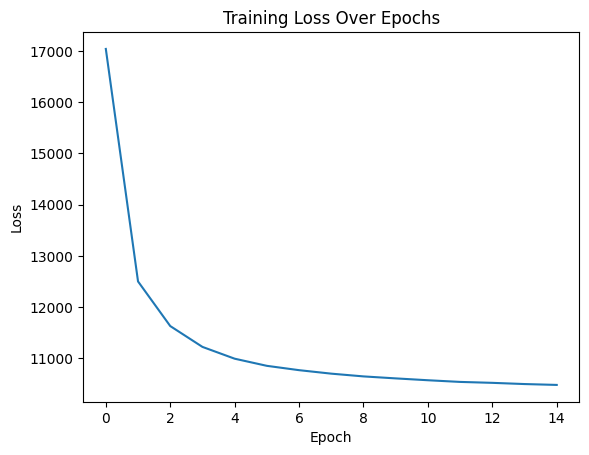

In [10]:
import matplotlib.pyplot as plt

# Init training
print("Start training...")

epoch_losses = []

for epoch in range(epochs):
    loop = tqdm(enumerate(train_loader))
    total_loss = 0
    batch_count = 0
    
    for i, (x,_) in loop:
        # Forward
        x = x.to(DEVICE).view(x.shape[0], x_dim)
        theta, mean, sigma = model(x)
        
        # Backpropagation
        loss = loss_function(x, theta, mean, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(loss=loss.item())

    epoch_loss = total_loss / batch_count
    epoch_losses.append(epoch_loss)

# Plotting
plt.plot(range(epochs), epoch_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

    

  5%|▌         | 5/100 [00:00<00:09, 10.27it/s]


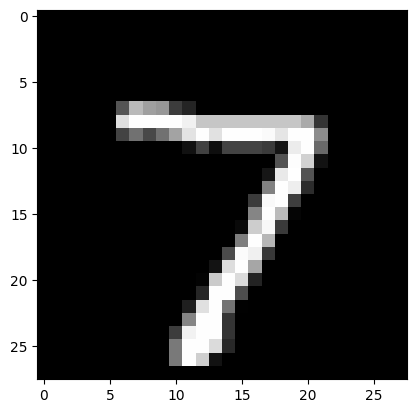

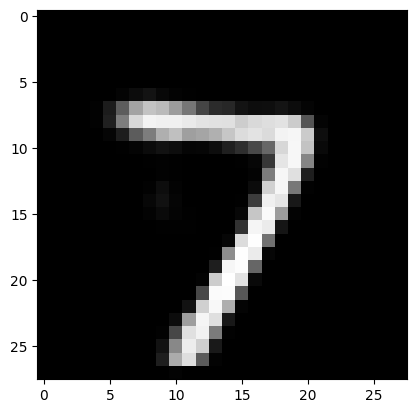

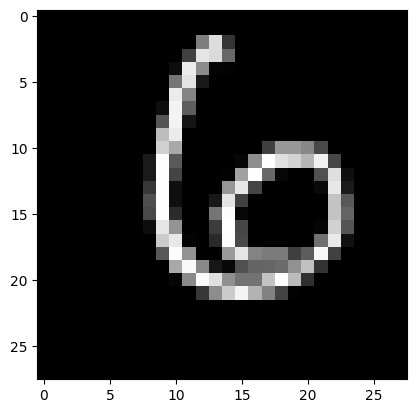

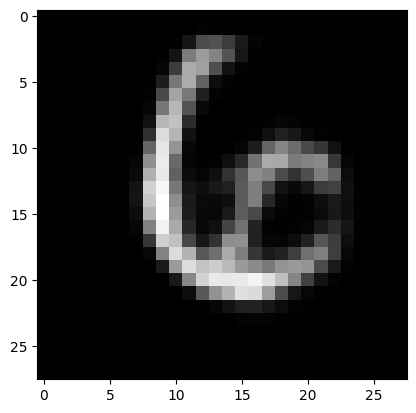

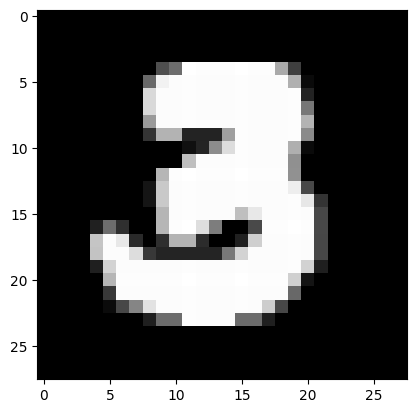

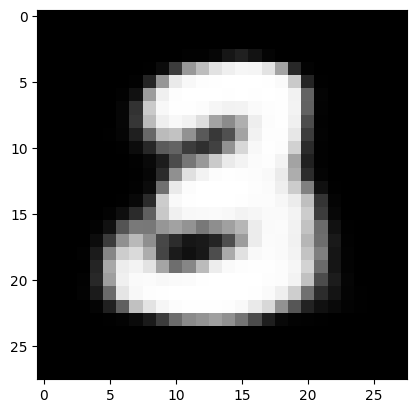

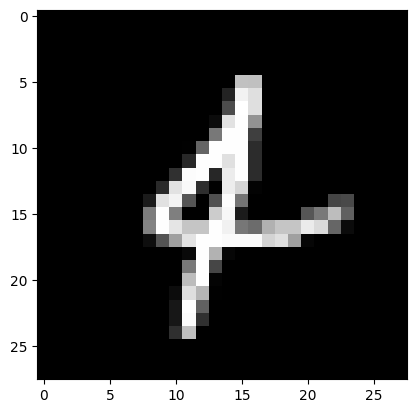

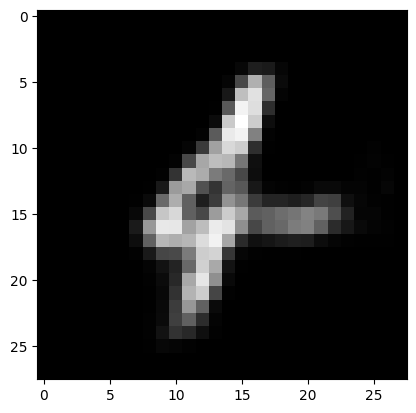

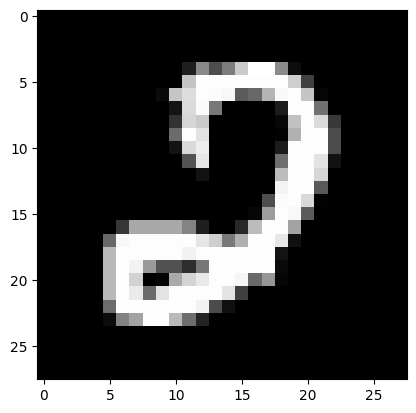

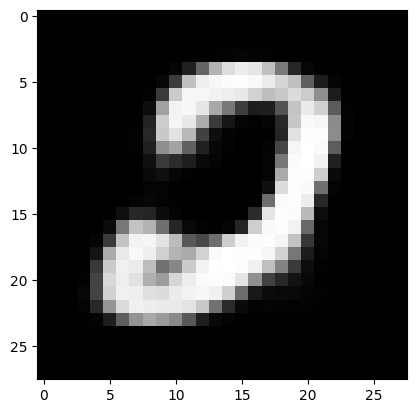

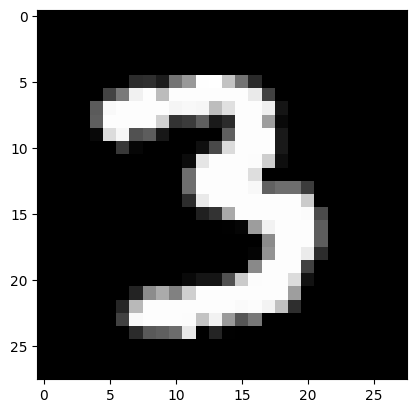

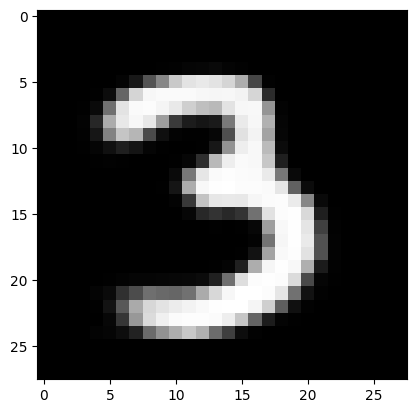

In [12]:

import matplotlib.pyplot as plt
def show_image(theta, idx):
    x_hat = theta.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x_hat[idx].cpu().numpy(), cmap='gray')

from torchvision.utils import save_image

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        
        # Generate theta from x
        theta, _, _ = model(x)
        
        # Display the original and reconstructed images
        show_image(x, idx=0)  # Original Image
        show_image(theta, idx=0)  # Reconstructed Image

        # Display a few examples and then break the loop
        if batch_idx == 5:
            break
